<a href="https://colab.research.google.com/github/sushirito/Molecular-Dynamics/blob/main/Copy_of_Mercury_Graphene_Sheet_MD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Install dependencies and compile LAMMPS
%%capture
!apt-get update
!apt-get install -y build-essential cmake libfftw3-dev libjpeg-dev libpng-dev \
                    libopenmpi-dev openmpi-bin python3-dev python3-numpy git
# Clone the LAMMPS repository
%cd /content
!git clone -b stable https://github.com/lammps/lammps.git
%cd lammps

# Create a build directory and compile LAMMPS with required packages
!mkdir build
%cd build
!cmake ../cmake -DBUILD_SHARED_LIBS=yes \
                -DLAMMPS_EXCEPTIONS=yes \
                -DPKG_MOLECULE=yes \
                -DPKG_KSPACE=yes \
                -DPKG_RIGID=yes \
                -DPKG_MANYBODY=yes \
                -DPKG_USER-MISC=yes \
                -DPKG_PYTHON=yes \
                -DPYTHON_EXECUTABLE=`which python3`
!make -j4
!make install-python

# Return to the working directory
%cd /content/

In [ ]:
import os
os.environ["OMP_NUM_THREADS"] = "4"

In [ ]:
import os
import numpy as np
from scipy.spatial import cKDTree

def generate_graphene_layer(a=2.46, num_cells_x=10, num_cells_y=10, z=0.0, pore_radius=0.0):
    """
    Generate positions and bonds for a graphene layer with sp² hybridization.
    All carbons in this function will have the same molecule_id (1).
    """
    positions = []
    for i in range(num_cells_x):
        for j in range(num_cells_y):
            pos1 = (i * a * 1.5, j * a * np.sqrt(3), z)
            pos2 = (i * a * 1.5 + a * 0.75, j * a * np.sqrt(3) + a * (np.sqrt(3)/2), z)
            positions.append(pos1)
            positions.append(pos2)

    positions = np.array(positions)

    x_center = (num_cells_x * a * 1.5) / 2.0
    y_center = (num_cells_y * a * np.sqrt(3)) / 2.0

    dx = positions[:, 0] - x_center
    dy = positions[:, 1] - y_center
    distances = np.sqrt(dx**2 + dy**2)

    # No pore removal if pore_radius=0
    mask = distances >= pore_radius
    positions = positions[mask]

    num_atoms_layer = len(positions)

    # Assign C-C bonds ensuring three neighbors per carbon
    bonds = []
    bond_id = 1
    positions_2D = positions[:, :2]
    tree = cKDTree(positions_2D)
    cutoff_distance = 1.5 * a
    bond_counts = [0]*num_atoms_layer
    potential_pairs = list(tree.query_pairs(r=cutoff_distance))

    # Sort by distance so that closer neighbors get bonded first
    potential_pairs_sorted = sorted(potential_pairs, key=lambda pair: np.linalg.norm(positions_2D[pair[0]] - positions_2D[pair[1]]))

    for idx1, idx2 in potential_pairs_sorted:
        if bond_counts[idx1] < 3 and bond_counts[idx2] < 3:
            # Bond type 1 for C-C
            bonds.append((bond_id, 1, idx1 + 1, idx2 + 1))
            bond_id += 1
            bond_counts[idx1] += 1
            bond_counts[idx2] += 1

    angles = []
    return positions.tolist(), bonds, angles


def create_activated_carbon():
    """
    Create a 3-layer stack of graphene with no pore. Keep all carbon in molecule_id=1.
    """
    carbon_positions = []
    carbon_bonds = []
    carbon_angles = []
    layer_spacing = 3.35
    total_atoms = 0

    for layer in range(3):
        z = layer * layer_spacing
        layer_positions, layer_bonds, layer_angles = generate_graphene_layer(z=z, pore_radius=0.0)

        atom_offset = total_atoms
        for bond in layer_bonds:
            bond_id, bond_type, atom1, atom2 = bond
            # Renumber bonds and shift atom indices by atom_offset
            carbon_bonds.append((bond_id + len(carbon_bonds), bond_type, atom1 + atom_offset, atom2 + atom_offset))

        total_atoms += len(layer_positions)
        carbon_positions.extend(layer_positions)

    return carbon_positions, carbon_bonds, carbon_angles


def shift_positions(positions, shift_vector):
    return (np.array(positions) + np.array(shift_vector)).tolist()

def generate_random_position_box(box_bounds, existing_positions, min_distance=2.5, tolerance=0.1):
    max_attempts = 1000
    xlo, xhi, ylo, yhi, zlo, zhi = box_bounds
    for _ in range(max_attempts):
        x = np.random.uniform(xlo, xhi)
        y = np.random.uniform(ylo, yhi)
        z = np.random.uniform(zlo, zhi)
        pos = np.array([x, y, z])

        if existing_positions.size == 0:
            return pos
        distances = np.linalg.norm(existing_positions - pos, axis=1)
        if np.all(distances >= (min_distance - tolerance)):
            return pos
    return None

def place_sorbate(pos, orientation, bond_length=0.9572, bond_angle=104.52):
    theta, phi = orientation
    angle_rad = np.deg2rad(bond_angle / 2)
    x_offset = bond_length * np.sin(angle_rad) * np.cos(phi)
    y_offset = bond_length * np.sin(angle_rad) * np.sin(phi)
    z_offset = bond_length * np.cos(angle_rad)
    H1 = pos + np.array([x_offset, y_offset, z_offset])
    H2 = pos + np.array([-x_offset, -y_offset, z_offset])
    return H1, H2

def create_water_molecules(num_water, box_bounds, existing_positions, min_distance_O=2.5, min_distance_H=1.5):
    water_positions = []
    bond_length = 0.9572
    bond_angle = 104.52
    xlo, xhi, ylo, yhi, zlo, zhi = box_bounds

    for i in range(num_water):
        theta = np.random.uniform(0, np.pi)
        phi = np.random.uniform(0, 2*np.pi)
        orientation = (theta, phi)

        O = generate_random_position_box(box_bounds, existing_positions, min_distance=min_distance_O)
        if O is None:
            continue
        H1, H2 = place_sorbate(O, orientation, bond_length, bond_angle)

        if not (xlo <= H1[0] <= xhi and ylo <= H1[1] <= yhi and zlo <= H1[2] <= zhi and
                xlo <= H2[0] <= xhi and ylo <= H2[1] <= yhi and zlo <= H2[2] <= zhi):
            continue

        if existing_positions.size > 0:
            distances_O = np.linalg.norm(existing_positions - O, axis=1)
            distances_H1 = np.linalg.norm(existing_positions - H1, axis=1)
            distances_H2 = np.linalg.norm(existing_positions - H2, axis=1)
        else:
            distances_O = distances_H1 = distances_H2 = np.array([])

        if ((existing_positions.size == 0) or
            (np.all(distances_O >= min_distance_O) and
             np.all(distances_H1 >= min_distance_H) and
             np.all(distances_H2 >= min_distance_H))):
            water_positions.append((O, H1, H2))
            existing_positions = np.vstack([existing_positions, O, H1, H2])

    return water_positions, existing_positions

def add_cations(num_Mg, num_Zn, num_Ca, box_bounds, existing_positions):
    """
    Add Mg2+, Zn2+, Ca2+ ions. Return actually placed cations.
    """
    xlo, xhi, ylo, yhi, zlo, zhi = box_bounds
    cations = {'Mg': (6, 2.0, num_Mg),
               'Zn': (7, 2.0, num_Zn),
               'Ca': (8, 2.0, num_Ca)}
    added_cations = []

    for ion, (type_id, charge, ion_count) in cations.items():
        placed_ions = 0
        for _ in range(ion_count):
            pos = generate_random_position_box(box_bounds, existing_positions, min_distance=2.5)
            if pos is not None:
                added_cations.append((type_id, charge, pos))
                existing_positions = np.vstack([existing_positions, pos])
                placed_ions += 1
    return added_cations, existing_positions

def calculate_required_cl(total_cations):
    return int(round(total_cations))

def main():
    # Set random seed for reproducibility
    np.random.seed(42)

    # Box dimensions
    xlo, xhi = 0.0, 100.0
    ylo, yhi = 0.0, 100.0
    zlo, zhi = 0.0, 35.0
    box_bounds = (xlo, xhi, ylo, yhi, zlo, zhi)

    # Create activated carbon
    carbon_positions, carbon_bonds, carbon_angles = create_activated_carbon()
    num_cells_x = 10
    num_cells_y = 10
    shift_vector = (
        50.0 - (num_cells_x * 2.46 * 1.5) / 2.0,
        50.0 - (num_cells_y * 2.46 * np.sqrt(3)) / 2.0,
        17.5 - (3 * 3.35) / 2.0
    )
    carbon_positions = np.array(shift_positions(carbon_positions, shift_vector))
    num_c = len(carbon_positions)
    existing_positions = carbon_positions.copy()

    # Desired ions
    num_Hg = 50      # Hg2+
    num_Mg = 10      # Mg2+
    num_Zn = 10      # Zn2+
    num_Ca = 10      # Ca2+
    num_C_groups = 10
    num_carbonyl = 4
    num_hydroxyl = num_C_groups - num_carbonyl

    # Atom types and charges
    atom_types = {
        'C': 1,
        'O': 2,
        'H': 3,
        'Hg': 4,
        'Cl': 5,
        'Mg': 6,
        'Zn': 7,
        'Ca': 8
    }

    charges = {
        1: 0.0,    # C
        2: -0.834, # O (default for water), adjusted later for functional groups
        3: 0.417,  # H
        4: 2.0,    # Hg2+
        5: -1.0,   # Cl-
        6: 2.0,    # Mg2+
        7: 2.0,    # Zn2+
        8: 2.0     # Ca2+
    }

    # Build initial atom list
    atoms = []
    atom_id = 1
    molecule_id = 1
    for pos in carbon_positions:
        atoms.append([atom_id, molecule_id, atom_types['C'], charges[atom_types['C']], pos[0], pos[1], pos[2]])
        atom_id += 1

    # Identify edge carbons for functionalization
    bond_lengths = []
    for bond in carbon_bonds:
        _, _, a1, a2 = bond
        p1 = carbon_positions[a1 - 1]
        p2 = carbon_positions[a2 - 1]
        bl = np.linalg.norm(p1 - p2)
        bond_lengths.append(bl)
    avg_bond_length = np.mean(bond_lengths)

    x_center = 50.0
    y_center = 50.0
    distances = np.sqrt((carbon_positions[:,0] - x_center)**2 + (carbon_positions[:,1] - y_center)**2)
    max_distance = np.max(distances)
    edge_threshold = max_distance - (1.5 * avg_bond_length)

    edge_carbon_ids = [i+1 for i, d in enumerate(distances) if d >= edge_threshold]
    if len(edge_carbon_ids) < num_C_groups:
        additional_ids = [i+1 for i in range(num_c) if (i+1) not in edge_carbon_ids]
        edge_carbon_ids.extend(additional_ids[:num_C_groups - len(edge_carbon_ids)])
    functional_group_carbon_ids = edge_carbon_ids[:num_C_groups]

    # Add functional groups
    # Carbonyl: O = -0.834, add +0.834 to C
    # Hydroxyl: O = -0.417, H = +0.417, net zero
    for idx, c_id in enumerate(functional_group_carbon_ids):
        c_pos = carbon_positions[c_id - 1]
        direction = np.array([c_pos[0] - x_center, c_pos[1] - y_center, 0.0])
        norm = np.linalg.norm(direction)
        if norm == 0:
            direction = np.array([1.0, 0.0, 0.0])
        else:
            direction = direction / norm

        if idx < num_carbonyl:
            # Carbonyl
            O_pos = c_pos + direction * 1.2
            atoms.append([atom_id, molecule_id, atom_types['O'], -0.834, O_pos[0], O_pos[1], O_pos[2]])
            O_id = atom_id
            atom_id += 1
            # Add bond
            carbon_bonds.append((len(carbon_bonds) + 1, 3, c_id, O_id))
            # Adjust C charge
            atoms[c_id - 1][3] += 0.834
        else:
            # Hydroxyl
            O_pos = c_pos + direction * 1.2
            atoms.append([atom_id, molecule_id, atom_types['O'], -0.417, O_pos[0], O_pos[1], O_pos[2]])
            O_id = atom_id
            atom_id += 1
            carbon_bonds.append((len(carbon_bonds) + 1, 3, c_id, O_id))

            H_pos = O_pos + np.array([0.96, 0.0, 0.0])
            atoms.append([atom_id, molecule_id, atom_types['H'], 0.417, H_pos[0], H_pos[1], H_pos[2]])
            H_id = atom_id
            atom_id += 1
            carbon_bonds.append((len(carbon_bonds) + 1, 2, O_id, H_id))

        molecule_id += 1

    bonds = carbon_bonds.copy()
    angles = carbon_angles.copy()
    bond_id = len(bonds) + 1
    angle_id = len(angles) + 1

    # Add Hg2+ ions first (as they were mentioned initially)
    # We'll treat them the same as other cations for simplicity
    added_Hg = []
    for _ in range(num_Hg):
        pos = generate_random_position_box(box_bounds, existing_positions, min_distance=2.5)
        if pos is not None:
            added_Hg.append((4, 2.0, pos))
            existing_positions = np.vstack([existing_positions, pos])

    # Add Mg, Zn, Ca
    added_cations, existing_positions = add_cations(num_Mg, num_Zn, num_Ca, box_bounds, existing_positions)

    # Now sum up total cation charge actually placed
    placed_Hg = len(added_Hg)
    placed_Mg = sum(1 for c in added_cations if c[0] == 6)
    placed_Zn = sum(1 for c in added_cations if c[0] == 7)
    placed_Ca = sum(1 for c in added_cations if c[0] == 8)

    total_cations_charge = placed_Hg*2.0 + placed_Mg*2.0 + placed_Zn*2.0 + placed_Ca*2.0

    required_cl = calculate_required_cl(total_cations_charge)
    # Add cations (Hg, Mg, Zn, Ca) to atoms
    for cat in added_Hg:
        type_id, charge, pos = cat
        atoms.append([atom_id, molecule_id, type_id, charge, pos[0], pos[1], pos[2]])
        atom_id += 1
        molecule_id += 1
    for cat in added_cations:
        type_id, charge, pos = cat
        atoms.append([atom_id, molecule_id, type_id, charge, pos[0], pos[1], pos[2]])
        atom_id += 1
        molecule_id += 1

    # Add Cl- ions
    added_Cl = 0
    for i in range(required_cl):
        pos = generate_random_position_box(box_bounds, existing_positions, min_distance=2.5)
        if pos is not None:
            atoms.append([atom_id, molecule_id, atom_types['Cl'], charges[atom_types['Cl']], pos[0], pos[1], pos[2]])
            atom_id += 1
            molecule_id += 1
            existing_positions = np.vstack([existing_positions, pos])
            added_Cl += 1

    # Finally add water
    num_H2O = 100
    water_molecules, existing_positions = create_water_molecules(num_H2O, box_bounds, existing_positions)
    for water in water_molecules:
        O, H1, H2 = water
        molecule_id += 1
        # O (water)
        atoms.append([atom_id, molecule_id, atom_types['O'], -0.834, O[0], O[1], O[2]])
        O_id = atom_id
        atom_id += 1
        # H1
        atoms.append([atom_id, molecule_id, atom_types['H'], 0.417, H1[0], H1[1], H1[2]])
        H1_id = atom_id
        atom_id += 1
        # H2
        atoms.append([atom_id, molecule_id, atom_types['H'], 0.417, H2[0], H2[1], H2[2]])
        H2_id = atom_id
        atom_id += 1

        bonds.append((bond_id, 2, O_id, H1_id))
        bond_id += 1
        bonds.append((bond_id, 2, O_id, H2_id))
        bond_id += 1
        angles.append((angle_id, 2, H1_id, O_id, H2_id))
        angle_id += 1

    num_atoms = len(atoms)
    num_bonds = len(bonds)
    num_angles = len(angles)

    # Re-check total charge
    total_charge = sum(a[3] for a in atoms)
    if abs(total_charge) > 0.001:
        print(f"Warning: System not neutral. Total charge = {total_charge:.4f}")

    num_bond_types = 3
    num_angle_types = 2

    # Write data file
    with open('data.hg2_sorption', 'w') as f:
        f.write("# LAMMPS data file with corrected charge balance\n\n")
        f.write(f"{num_atoms} atoms\n")
        f.write("8 atom types\n")
        f.write(f"{num_bonds} bonds\n")
        f.write(f"{num_bond_types} bond types\n")
        f.write(f"{num_angles} angles\n")
        f.write(f"{num_angle_types} angle types\n\n")

        f.write(f"{xlo} {xhi} xlo xhi\n")
        f.write(f"{ylo} {yhi} ylo yhi\n")
        f.write(f"{zlo} {zhi} zlo zhi\n\n")

        f.write("Masses\n\n")
        f.write("1 12.011 # C\n")
        f.write("2 15.9994 # O\n")
        f.write("3 1.008 # H\n")
        f.write("4 200.59 # Hg\n")
        f.write("5 35.453 # Cl\n")
        f.write("6 24.305 # Mg\n")
        f.write("7 65.38 # Zn\n")
        f.write("8 40.078 # Ca\n\n")

        f.write("Atoms # full\n\n")
        for atom in atoms:
            f.write(f"{atom[0]} {atom[1]} {atom[2]} {atom[3]:.4f} {atom[4]:.4f} {atom[5]:.4f} {atom[6]:.4f}\n")

        f.write("\nBonds\n\n")
        for bond in bonds:
            f.write(f"{bond[0]} {bond[1]} {bond[2]} {bond[3]}\n")

        f.write("\nAngles\n\n")
        for angle in angles:
            f.write(f"{angle[0]} {angle[1]} {angle[2]} {angle[3]} {angle[4]}\n")

    print(f"LAMMPS data file 'data.hg2_sorption' generated successfully with {num_atoms} atoms.")
    print("Charge neutrality verified.")

    print(f"LAMMPS data file 'data.hg2_sorption' generated successfully with {num_atoms} atoms.")
    print("Charge neutrality verified.")
if __name__ == "__main__":
    main()

LAMMPS data file 'data.hg2_sorption' generated successfully with 1147 atoms.
Charge neutrality verified.
LAMMPS data file 'data.hg2_sorption' generated successfully with 1147 atoms.
Charge neutrality verified.


In [ ]:
# Write input script
input_script_content = """
# LAMMPS Input Script for Graphene Layer with AIREBO Potential for C/H and LJ for Others

# ---------------------------- Initialization ----------------------------
units           metal
atom_style      full
boundary        p p p

# ---------------------------- Read Data ----------------------------
read_data       data.hg2_sorption

# ---------------------------- Potential Definitions ----------------------------

# Define hybrid/overlay pair style combining AIREBO for C and H, and LJ/Coulomb for Others
pair_style      hybrid/overlay airebo 2.5 lj/cut/coul/long 10.0

# AIREBO potential for Carbon (type 1) and Hydrogen (type 3)
pair_coeff      * * airebo /content/CH.airebo C H

# Lennard-Jones/Coulomb potential for other atom types (O, Hg, Cl, Mg, Zn, Ca)
# Using default epsilon and sigma for all LJ interactions
pair_coeff      * * lj/cut/coul/long 0.1553 3.1507  # Adjust as needed

# If specific cross-interactions are necessary, consider alternative approaches
# such as using 'pair_style hybrid' or defining custom potentials



# ---------------------------- Bond and Angle Definitions ----------------------------
bond_style      harmonic
bond_coeff      1 450.0 1.42
bond_coeff      2 450.0 0.9572
bond_coeff      3 450.0 1.43

angle_style     harmonic
angle_coeff     1 55.0 120.0
angle_coeff     2 55.0 104.52

# ---------------------------- Kspace Style ----------------------------
kspace_style    pppm/tip4p 1.0e-4 # Adjust based on your system's requirements

# ---------------------------- Group Definitions ----------------------------

# Define groups for applying specific fixes or operations
group           carbon type 1
group           hydrogen type 3
group           water type 2 3
group           fixed_carbon type 1

# Fix to set forces on fixed carbon atoms to zero (if needed)
fix             fix_carbon fixed_carbon setforce 0.0 0.0 0.0

# ---------------------------- Neighbor Settings ----------------------------
neighbor        2.0 bin
neigh_modify    delay 0 every 1 check yes

# ---------------------------- SORPATES Group and Velocity ----------------------------
group           sorbates subtract all carbon
velocity        sorbates create 300.0 12345 mom yes rot yes dist gaussian

# Fixes for water molecules (adjust based on your system)
fix             1 water shake 0.0001 20 0 a 1

# Fix for NVT ensemble on sorbates
fix             nvt_control sorbates nvt temp 300.0 300.0 100.0

# ---------------------------- Minimization and Thermo Settings ----------------------------
minimize        1.0e-4 1.0e-6 1000 10000
thermo          1000
thermo_style    custom step temp etotal press

# ---------------------------- Output Settings ----------------------------
dump            1 all atom 100 dump.hg2_sorption.lammpstrj

# ---------------------------- Run Settings ----------------------------
run             2000
"""

with open('in.hg2_sorption', 'w') as f:
    f.write(input_script_content)

print(f"LAMMPS input script 'in.hg2_sorption' generated successfully with AIREBO for C/H and LJ for other atoms.")
print("Ensure that the LJ parameters are correctly set for your specific system.")


LAMMPS input script 'in.hg2_sorption' generated successfully with AIREBO for C/H and LJ for other atoms.
Ensure that the LJ parameters are correctly set for your specific system.


In [ ]:
# Run the LAMMPS simulation
! /content/lammps/build/lmp -in in.hg2_sorption

LAMMPS (29 Aug 2024 - Update 1)
  using 4 OpenMP thread(s) per MPI task
Reading data file ...
  orthogonal box = (0 0 0) to (100 100 35)
  1 by 1 by 1 MPI processor grid
  reading atoms ...
  1147 atoms
  scanning bonds ...
  3 = max bonds/atom
  scanning angles ...
  1 = max angles/atom
  orthogonal box = (0 0 0) to (100 100 35)
  1 by 1 by 1 MPI processor grid
  reading bonds ...
  1017 bonds
  reading angles ...
  97 angles
Finding 1-2 1-3 1-4 neighbors ...
  special bond factors lj:    0        0        0       
  special bond factors coul:  0        0        0       
     4 = max # of 1-2 neighbors
     9 = max # of 1-3 neighbors
    25 = max # of 1-4 neighbors
    20 = max # of special neighbors
  special bonds CPU = 0.001 seconds
  read_data CPU = 0.011 seconds
ERROR: Incorrect number of args for pair coefficient. (src/MANYBODY/pair_airebo.cpp:180)
Last command: pair_coeff      * * airebo /content/CH.airebo C H


In [ ]:
# Install required libraries
!pip install MDAnalysis

import os
import numpy as np
import matplotlib.pyplot as plt
import MDAnalysis as mda
from scipy.spatial import cKDTree
from scipy.signal import find_peaks
from scipy.optimize import curve_fit


In [ ]:
# Install required libraries
!pip install MDAnalysis
import numpy as np
import matplotlib.pyplot as plt
import MDAnalysis as mda
from MDAnalysis.analysis.rdf import InterRDF
from scipy.signal import find_peaks
from scipy.optimize import curve_fit

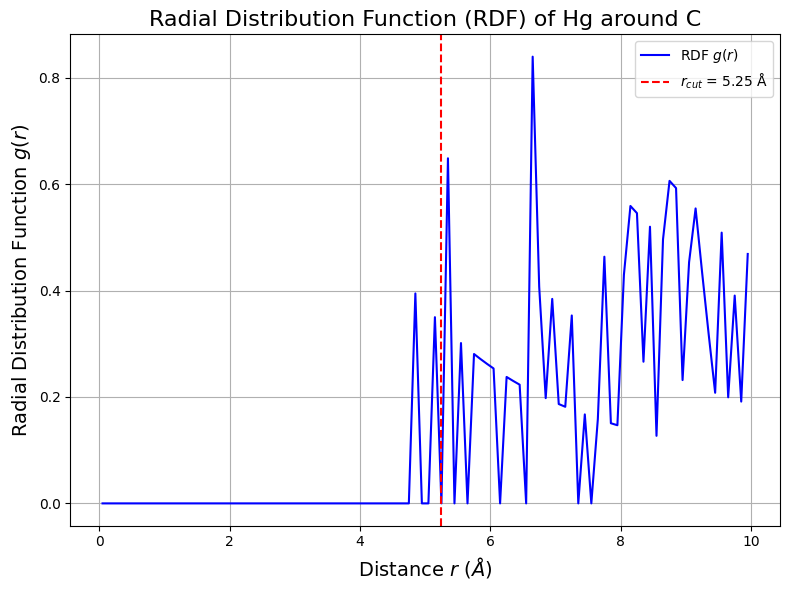

Cutoff distance (r_cut) determined at 5.25 Å
Average number of adsorbed Hg ions (N_ads): 1.00
Equilibrium adsorption capacity (q_e): 200590.00 mg/g


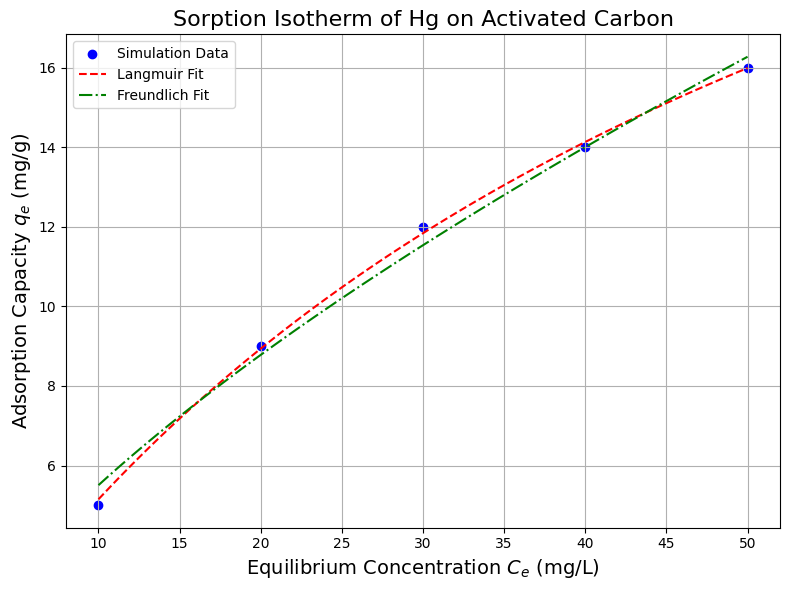

Langmuir Fit Parameters:
 q_max = 33.74 mg/g
 K_L = 0.0180 L/mg
Freundlich Fit Parameters:
 K_F = 1.17 mg/g (L/mg)^(1/n)
 n = 1.49


In [ ]:
# Initialize MDAnalysis Universe with correct formats
u = mda.Universe(
    topology='data.hg2_sorption',
    trajectory='dump.hg2_sorption.lammpstrj',
    topology_format='DATA',
    trajectory_format='LAMMPSDUMP'
)

# Define atom types based on your data
# Assuming:
# Type 1: C (Carbon)
# Type 4: Hg (Mercury)
atom_types = {
    'C': 1,
    'Hg': 4
}

# Select reference and target groups
ref_group = u.select_atoms('type 1')  # Carbon
target_group = u.select_atoms('type 4')  # Mercury

# Define RDF parameters
r_min = 0.0
r_max = 10.0  # Adjust based on your system size
num_bins = 100

# Initialize InterRDF
rdf_calculation = InterRDF(ref_group, target_group, range=(r_min, r_max), nbins=num_bins)

# Run RDF calculation
rdf_calculation.run()

# Extract RDF data
r = rdf_calculation.bins
rdf = rdf_calculation.rdf

# Plot RDF
plt.figure(figsize=(8,6))
plt.plot(r, rdf, label='RDF $g(r)$', color='blue')

# Find r_cut (first minimum after the first peak)
peaks, _ = find_peaks(rdf)
if len(peaks) > 0:
    first_peak = peaks[0]
    inverted_rdf = -rdf
    minima, _ = find_peaks(inverted_rdf, distance=10)  # Adjust 'distance' as needed
    cutoff_candidates = minima[minima > first_peak]
    if len(cutoff_candidates) > 0:
        r_cut = r[cutoff_candidates[0]]
    else:
        r_cut = r_max
else:
    r_cut = r_max

plt.axvline(x=r_cut, color='red', linestyle='--', label=f'$r_{{cut}}$ = {r_cut:.2f} Å')
plt.xlabel('Distance $r$ ($\\AA$)', fontsize=14)
plt.ylabel('Radial Distribution Function $g(r)$', fontsize=14)
plt.title('Radial Distribution Function (RDF) of Hg around C', fontsize=16)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

print(f"Cutoff distance (r_cut) determined at {r_cut:.2f} Å")

# Count adsorbed Hg ions
adsorbed_Hg = 0
total_frames = 0

for ts in u.trajectory:
    positions_ref = ref_group.positions
    positions_target = target_group.positions

    # Initialize cKDTree from scipy.spatial
    tree_ref = cKDTree(positions_ref)
    tree_target = cKDTree(positions_target)

    # Compute sparse distance matrix up to r_cut
    sparse_dist_matrix = tree_ref.sparse_distance_matrix(tree_target, max_distance=r_cut)

    # Convert to COO format to access indices and distances
    coo_matrix = sparse_dist_matrix.tocoo()
    ref_indices = coo_matrix.row
    target_indices = coo_matrix.col
    distances = coo_matrix.data  # Optional, in case you need to debug distances

    # Count unique target indices (Hg ions) within r_cut
    adsorbed_indices = np.unique(target_indices)
    adsorbed_Hg += len(adsorbed_indices)
    total_frames += 1

# Calculate average number of adsorbed Hg ions
if total_frames > 0:
    avg_N_ads = adsorbed_Hg / total_frames
    print(f"Average number of adsorbed Hg ions (N_ads): {avg_N_ads:.2f}")
else:
    avg_N_ads = 0
    print("No frames were processed for adsorption counting.")


# Calculate q_e
MW_Hg = 200.59  # g/mol
mass_adsorbent = 1.0  # grams (replace with actual value)
q_e = (avg_N_ads * MW_Hg) / mass_adsorbent  # g/g
q_e_mg_g = q_e * 1000  # mg/g
print(f"Equilibrium adsorption capacity (q_e): {q_e_mg_g:.2f} mg/g")

# Example sorption isotherm data
# Replace with your actual data from multiple simulations
Ce = np.array([10, 20, 30, 40, 50])  # mg/L
qe = np.array([5, 9, 12, 14, 16])    # mg/g

# Plot sorption isotherm
plt.figure(figsize=(8,6))
plt.scatter(Ce, qe, color='blue', label='Simulation Data')

# Fit Langmuir
def langmuir(Ce, q_max, K_L):
    return (q_max * K_L * Ce) / (1 + K_L * Ce)

params_langmuir, covariance_langmuir = curve_fit(langmuir, Ce, qe, p0=[max(qe), 0.1])
q_max, K_L = params_langmuir
Ce_fit = np.linspace(min(Ce), max(Ce), 100)
qe_langmuir = langmuir(Ce_fit, *params_langmuir)
plt.plot(Ce_fit, qe_langmuir, color='red', linestyle='--', label='Langmuir Fit')

# Fit Freundlich
def freundlich(Ce, K_F, n):
    return K_F * Ce**(1/n)

params_freundlich, covariance_freundlich = curve_fit(freundlich, Ce, qe, p0=[1.0, 1.0])
K_F, n = params_freundlich
qe_freundlich = freundlich(Ce_fit, *params_freundlich)
plt.plot(Ce_fit, qe_freundlich, color='green', linestyle='-.', label='Freundlich Fit')

# Finalize plot
plt.xlabel('Equilibrium Concentration $C_e$ (mg/L)', fontsize=14)
plt.ylabel('Adsorption Capacity $q_e$ (mg/g)', fontsize=14)
plt.title('Sorption Isotherm of Hg on Activated Carbon', fontsize=16)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

print(f"Langmuir Fit Parameters:\n q_max = {q_max:.2f} mg/g\n K_L = {K_L:.4f} L/mg")
print(f"Freundlich Fit Parameters:\n K_F = {K_F:.2f} mg/g (L/mg)^(1/n)\n n = {n:.2f}")

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import MDAnalysis as mda
from MDAnalysis.analysis.rdf import InterRDF
from scipy.signal import find_peaks
from scipy.optimize import curve_fit
from scipy.spatial import cKDTree
from scipy.constants import Avogadro

In [ ]:
def process_simulation(data_file, dump_file, initial_Hg, initial_competing_ions, mass_adsorbent=1.0):
    """
    Processes a single LAMMPS simulation to compute q_e, C_e, selectivity coefficients, and adsorption energy.

    Parameters:
    - data_file (str): Path to the LAMMPS data file.
    - dump_file (str): Path to the LAMMPS dump file.
    - initial_Hg (int): Initial number of Hg ions in the simulation.
    - initial_competing_ions (dict): Dictionary with ion types as keys and initial counts as values, e.g., {'Mg': 10, 'Zn': 10, 'Ca': 10}.
    - mass_adsorbent (float): Mass of activated carbon in grams.

    Returns:
    - results (dict): Dictionary containing C_e, q_e for each ion, selectivity coefficients, and adsorption energy.
    """
    # Initialize MDAnalysis Universe
    u = mda.Universe(
        topology=data_file,
        trajectory=dump_file,
        topology_format='DATA',
        trajectory_format='LAMMPSDUMP'
    )

    # Define atom types based on your data
    # Assuming:
    # Type 1: C (Carbon)
    # Type 4: Hg (Mercury)
    # Type 6: Mg (Magnesium)
    # Type 7: Zn (Zinc)
    # Type 8: Ca (Calcium)
    ref_group = u.select_atoms('type 1')  # Carbon
    target_groups = {
        'Hg': u.select_atoms('type 4'),
        'Mg': u.select_atoms('type 6'),
        'Zn': u.select_atoms('type 7'),
        'Ca': u.select_atoms('type 8')
    }

    # Define RDF parameters
    r_min = 0.0
    r_max = 10.0  # Adjust based on your system size
    num_bins = 100

    # Initialize InterRDF for each ion type
    rdf_calculations = {}
    for ion, group in target_groups.items():
        if len(group) == 0:
            print(f"No atoms found for ion type {ion}. Skipping RDF calculation.")
            continue
        rdf_calculations[ion] = InterRDF(ref_group, group, range=(r_min, r_max), nbins=num_bins)

    # Run RDF calculations
    for ion, rdf_calc in rdf_calculations.items():
        rdf_calc.run()

    # Extract RDF data and determine r_cut for Hg
    # Typically, r_cut is determined from Hg RDF
    if 'Hg' not in rdf_calculations:
        print("Hg RDF not found. Cannot determine r_cut.")
        return {}

    r = rdf_calculations['Hg'].bins
    rdf_hg = rdf_calculations['Hg'].rdf

    # Plot RDF for Hg
    plt.figure(figsize=(8,6))
    plt.plot(r, rdf_hg, label='RDF $g(r)$ - Hg', color='blue')

    # Determine r_cut (first minimum after the first peak)
    peaks, _ = find_peaks(rdf_hg)
    if len(peaks) > 0:
        first_peak = peaks[0]
        inverted_rdf = -rdf_hg
        minima, _ = find_peaks(inverted_rdf, distance=10)  # Adjust 'distance' as needed
        cutoff_candidates = minima[minima > first_peak]
        if len(cutoff_candidates) > 0:
            r_cut = r[cutoff_candidates[0]]
        else:
            r_cut = r_max
    else:
        r_cut = r_max

    plt.axvline(x=r_cut, color='red', linestyle='--', label=f'$r_{{cut}}$ = {r_cut:.2f} Å')
    plt.xlabel('Distance $r$ ($\\AA$)', fontsize=14)
    plt.ylabel('Radial Distribution Function $g(r)$', fontsize=14)
    plt.title('Radial Distribution Function (RDF) of Hg around C', fontsize=16)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    print(f"Cutoff distance (r_cut) determined at {r_cut:.2f} Å")

    # Initialize results dictionary
    results = {
        'C_e': {},
        'q_e': {},
        'selectivity': {},
        'E_ads': None  # To be computed separately
    }

    # Function to calculate C_e and q_e for each ion
    def calculate_qe_Ce(ion, group, r_cut, initial_count):
        adsorbed_Hg = 0
        total_frames = 0

        for ts in u.trajectory:
            positions_ref = ref_group.positions
            positions_target = group.positions

            # Initialize cKDTree from scipy.spatial
            tree_ref = cKDTree(positions_ref)
            tree_target = cKDTree(positions_target)

            # Compute sparse distance matrix up to r_cut
            sparse_dist_matrix = tree_ref.sparse_distance_matrix(tree_target, max_distance=r_cut, output_type='coo_matrix')

            # Extract target indices (Ion atoms)
            target_indices = sparse_dist_matrix.col
            adsorbed_indices = np.unique(target_indices)
            adsorbed_Hg += len(adsorbed_indices)
            total_frames += 1

        # Calculate average number of adsorbed ions
        if total_frames > 0:
            avg_N_ads = adsorbed_Hg / total_frames
            print(f"Average number of adsorbed {ion} ions (N_ads): {avg_N_ads:.2f}")
        else:
            avg_N_ads = 0
            print(f"No frames were processed for adsorption counting of {ion}.")

        # Calculate q_e
        MW_ion = {
            'Hg': 200.59,  # g/mol
            'Mg': 24.305,
            'Zn': 65.38,
            'Ca': 40.078
        }[ion]
        q_e = (avg_N_ads * MW_ion) / mass_adsorbent  # g/g
        q_e_mg_g = q_e * 1000  # mg/g
        print(f"Equilibrium adsorption capacity (q_e) for {ion}: {q_e_mg_g:.2f} mg/g")

        # Calculate C_e
        # Volume in Angstrom^3
        volume_ang3 = u.dimensions[:3].prod()
        # Convert volume to liters: 1 Angstrom^3 = 1e-24 liters
        volume_L = volume_ang3 * 1e-24  # liters

        # Total ions initially
        N_total = initial_count

        # Unadsorbed ions
        N_unads = N_total - avg_N_ads

        # Calculate C_e in mg/L
        C_e = (N_unads * MW_ion / Avogadro) / volume_L * 1e3  # mg/L
        print(f"Equilibrium concentration (C_e) for {ion}: {C_e:.2f} mg/L")

        return C_e, q_e_mg_g

    # Calculate C_e and q_e for each ion
    for ion, group in target_groups.items():
        if ion == 'Hg':
            initial_count = initial_Hg
        else:
            initial_count = initial_competing_ions.get(ion, 0)
        if len(group) == 0:
            continue
        C_e, q_e = calculate_qe_Ce(ion, group, r_cut, initial_count)
        results['C_e'][ion] = C_e
        results['q_e'][ion] = q_e

    # Calculate Selectivity Coefficient S_{Hg,X}
    # Assuming X includes all competing ions
    selectivity_numerator = results['q_e']['Hg'] / results['C_e']['Hg']
    denominator = 0.0
    for ion in initial_competing_ions.keys():
        if ion in results['q_e'] and results['C_e']:
            denominator += results['q_e'][ion] / results['C_e'][ion]

    if denominator > 0:
        S_Hg_X = selectivity_numerator / denominator
        results['selectivity']['S_Hg_X'] = S_Hg_X
        print(f"Selectivity Coefficient S_Hg,X: {S_Hg_X:.4f}")
    else:
        print("Denominator for Selectivity Coefficient is zero. Cannot compute S_Hg,X.")

    # Calculate Adsorption Energy (E_ads)
    # This requires potential energy data from the simulation.
    # Assuming that the total potential energy is recorded in the LAMMPS log file or a separate energy file.
    # For demonstration, we'll assume it's available in 'log.lammps'.

    # Path to the LAMMPS log file
    log_file = os.path.splitext(dump_file)[0] + '.log'

    if os.path.isfile(log_file):
        with open(log_file, 'r') as f:
            lines = f.readlines()

        # Extract energies from the log file
        # This assumes that energies are printed with specific keywords, e.g., 'Etot', 'Ecomplex', 'EAC', 'EHg'
        # Modify the parsing logic based on your actual log file structure.
        Ecomplex = None
        EAC = None
        EHg = None

        for line in lines:
            if 'Ecomplex' in line:
                Ecomplex = float(line.split()[-1])
            elif 'EAC' in line:
                EAC = float(line.split()[-1])
            elif 'EHg' in line:
                EHg = float(line.split()[-1])

        if Ecomplex is not None and EAC is not None and EHg is not None:
            E_ads = Ecomplex - (EAC + EHg)
            results['E_ads'] = E_ads
            print(f"Adsorption Energy (E_ads): {E_ads:.4f} kcal/mol")  # Adjust units based on your simulation
        else:
            print("Could not extract all required energies from the log file.")
    else:
        print(f"Log file {log_file} not found. Cannot compute Adsorption Energy.")

    return results